This is my first attempt at creating and training my own neural network. I'll be training my model on the MNIST dataset to recognize numbers 0-9. This will be a convolutional neural network built from scratch. The problem is simple enough to not really need a pretrained base model.


I may try to expand this project to include a drawing board where users can draw their own numbers and have my model predict them.

# Imports #

In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split


SEED = 31415

np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading Data #

In [2]:
df_train = pd.read_csv("../input/digit-recognizer/train.csv")
print(df_train.shape)
df_train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
df_test = pd.read_csv("../input/digit-recognizer/test.csv")
print(df_test.shape)
df_test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Each image is represented using 784 features. Each feature represents a pixel in a 28\*28 grid. The pixels are numbered left to right, top to bottom where the top left pixel is pixel0 and the pixel directly below it is pixel28. The `label` feature in the training data is the represented number.

Each pixel can have a value from 0-255 where 0 is black and 255 is white.

# Data Analysis #



In [4]:
print("Missing values:")
print(df_train.isna().sum().sum())
print(df_test.isna().sum().sum())
print("------------------")
print(df_train.dtypes.value_counts())
print(df_test.dtypes.value_counts())

Missing values:
0
0
------------------
int64    785
Name: count, dtype: int64
int64    784
Name: count, dtype: int64


The dataset has no missing values and all columns are appropriately encoded as type `int64`. This reduces the amount of preprocessing needed.

<Axes: xlabel='label', ylabel='count'>

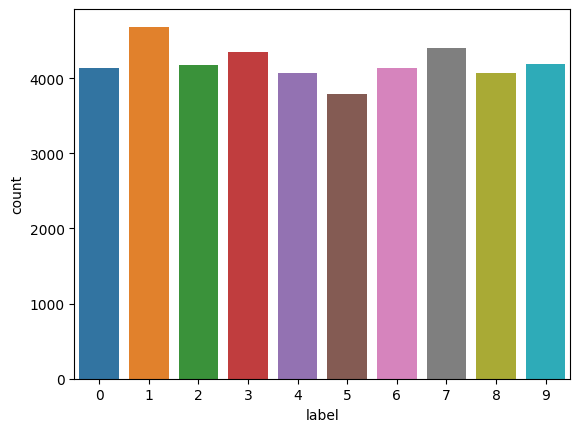

In [5]:
sns.countplot(x="label", data=df_train)

We have a fairly even distribution of numbers within the training set.

# Preprocessing #

We normalize the data and reshape it so that the CNN can handle it. 

In [6]:
X_train = df_train.copy()
y_train = X_train.pop("label")
X_test = df_test.copy()

#Normalize data
X_train = X_train / 255
X_test = X_test / 255

#Reshape data, 28x28, 1 channel
X_train = X_train.values.reshape(-1, 28, 28, 1)
X_test = X_test.values.reshape(-1, 28, 28, 1)

Here's a look at the first couple entries of our training data

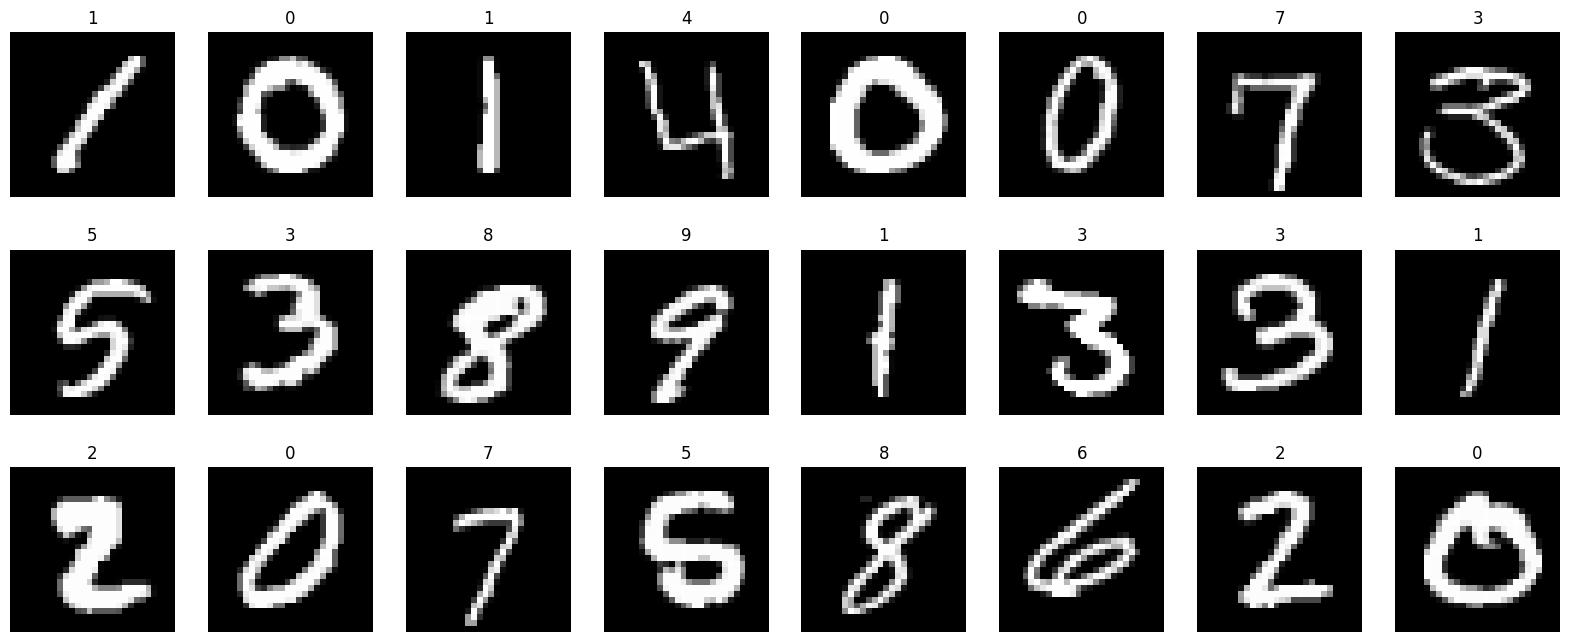

In [7]:
#Display first n X_train entries
n_rows, n_cols = 3, 8
fig, axs = plt.subplots(n_rows, n_cols, figsize=(20,8))
axs = axs.flatten()
for i in range(n_rows*n_cols):
    axs[i].imshow(X_train[i], cmap="gray") 
    axs[i].set_title(y_train[i])
    axs[i].axis("off")

One-hot encoding the target also helps the CNN training. 

In [8]:
#e.g. 4 becomes [0,0,0,0,1,0,0,0,0,0]
y_train = to_categorical(y_train, num_classes=10)

Now, we'll extract our validation data from our training data. Given that the dataset is relatively large, we'll use 10% of the training data as validation.

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=SEED)

# Model Creation and Training #

To create the convolutional base, I opted for 3 blocks with batch normalization, same padding, and global pooling. Same padding is important since the images are already low resolution and border values seem to mainly be 0. Global pooling and batch normalization should help reduce overfitting and allow the model to capture the overall patterns.

In [10]:
model = keras.Sequential([
    layers.InputLayer(shape=[28, 28, 1]),
    
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),
    
    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    
    layers.GlobalAveragePooling2D(),
    
    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,474 (400.29 KB)

 Trainable params: 102,026 (398.54 KB)

 Non-trainable params: 448 (1.75 KB)

Compile the model using Adam optimization

In [11]:
model.compile(optimizer="adam", 
              loss="categorical_crossentropy", 
              metrics=["accuracy"])

To help prevent overfitting, I also created a model to augment data. I chose to incorporate small amounts of rotation, zoom, and translation. I chose to exclude image flipping since that could drastically change the number being represented, especially with 6 and 9. I also tried to change brightness but the images seemed very sensitive to brightness changes and i couldn't get it to produce recognizable images consistently.

The augmenation seemed to work well because the validation loss followed the training loss much better after applying it.

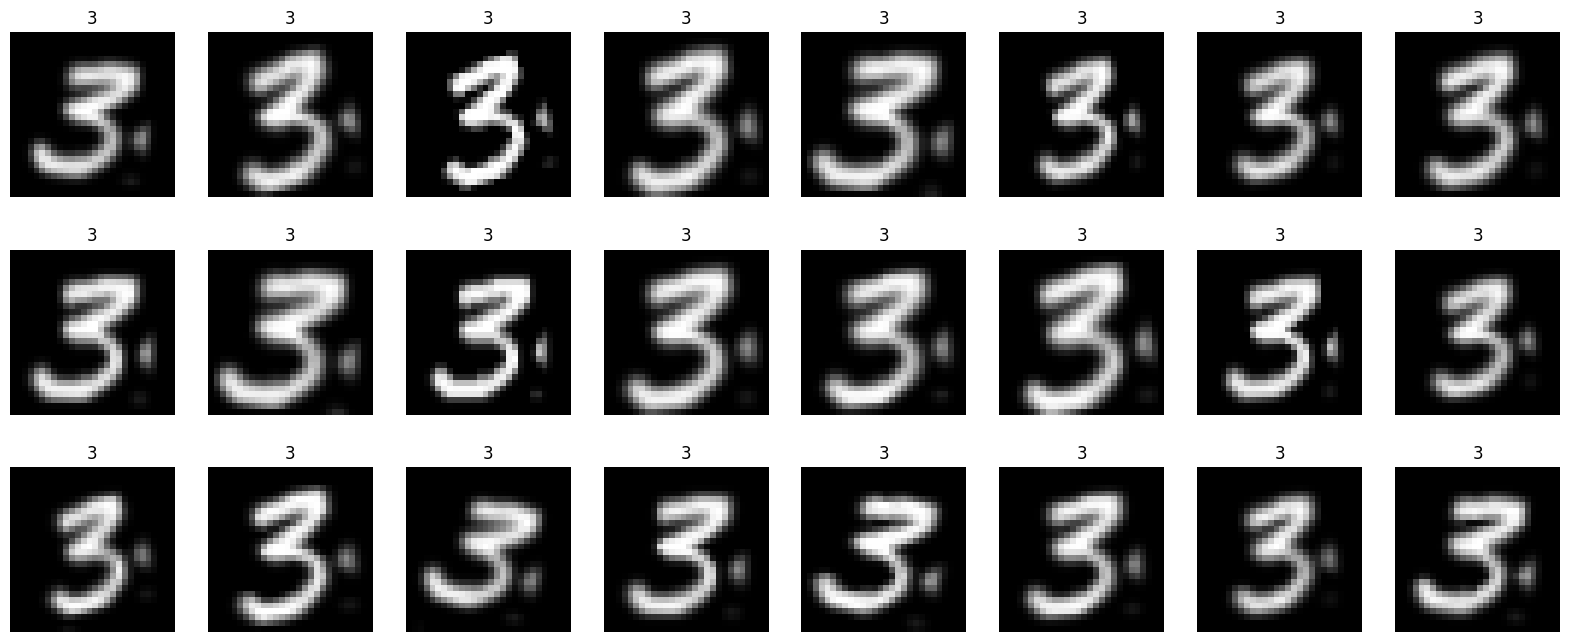

In [12]:
#Data augmentation
image_gen = keras.Sequential([
    layers.RandomRotation(0.05),
    layers.RandomZoom(0.15),
    layers.RandomHeight(0.1),
    layers.RandomWidth(0.1),
    layers.Resizing(28, 28),
])

#Show some augmented examples
image_index = 14
n_rows, n_cols = 3, 8

example = X_train[image_index]
label = np.argmax(y_train[image_index])
augmented_examples = [image_gen(example) for _ in range(n_rows*n_cols)]

fig, axs = plt.subplots(n_rows, n_cols, figsize=(20, 8))
axs = axs.flatten()
for i in range(n_rows * n_cols):
    axs[i].imshow(augmented_examples[i], cmap="gray")
    axs[i].set_title(label)
    axs[i].axis("off")

In [13]:
epochs = 20
batch_size = 64 

def preprocess(image, label):
    image = image_gen(image, training=True)  

    return image, label

ds_train = tf.data.Dataset.from_tensor_slices((X_train, y_train))
ds_val = tf.data.Dataset.from_tensor_slices((X_val, y_val))

ds_train = ds_train.map(preprocess).batch(batch_size).prefetch(tf.data.AUTOTUNE)
ds_val = ds_val.batch(batch_size).prefetch(tf.data.AUTOTUNE)

history = model.fit(ds_train,
                    validation_data=ds_val,
                    epochs=epochs,
                    verbose=1 )

Epoch 1/20


I0000 00:00:1725166038.285137      64 service.cc:145] XLA service 0x584f952f4580 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725166038.285216      64 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  7/591 ━━━━━━━━━━━━━━━━━━━━ 15s 27ms/step - accuracy: 0.2557 - loss: 2.1665

I0000 00:00:1725166042.441637      64 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


591/591 ━━━━━━━━━━━━━━━━━━━━ 33s 45ms/step - accuracy: 0.8164 - loss: 0.6546 - val_accuracy: 0.8590 - val_loss: 0.4273
Epoch 2/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.9741 - loss: 0.0915 - val_accuracy: 0.9602 - val_loss: 0.1206
Epoch 3/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 40ms/step - accuracy: 0.9770 - loss: 0.0726 - val_accuracy: 0.9802 - val_loss: 0.0621
Epoch 4/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.9827 - loss: 0.0567 - val_accuracy: 0.9738 - val_loss: 0.0796
Epoch 5/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 24s 40ms/step - accuracy: 0.9843 - loss: 0.0538 - val_accuracy: 0.9836 - val_loss: 0.0507
Epoch 6/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9861 - loss: 0.0461 - val_accuracy: 0.9698 - val_loss: 0.0959
Epoch 7/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 22s 37ms/step - accuracy: 0.9883 - loss: 0.0408 - val_accuracy: 0.9829 - val_loss: 0.0571
Epoch 8/20
591/591 ━━━━━━━━━━━━━━━━━━━━ 23s 39ms/step - accuracy: 0.9880 - loss: 0.0384 - val_accurac

Best validation loss: 0.028049958869814873
Best validation accuracy: 0.9916666746139526


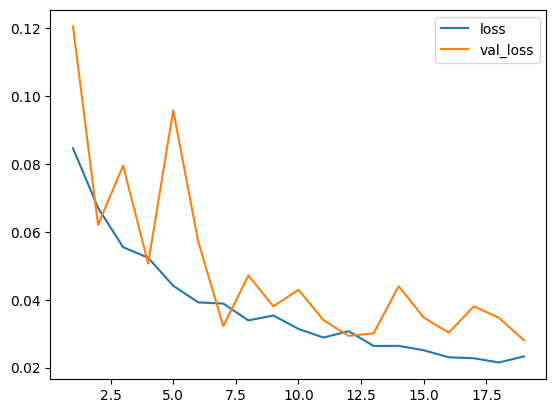

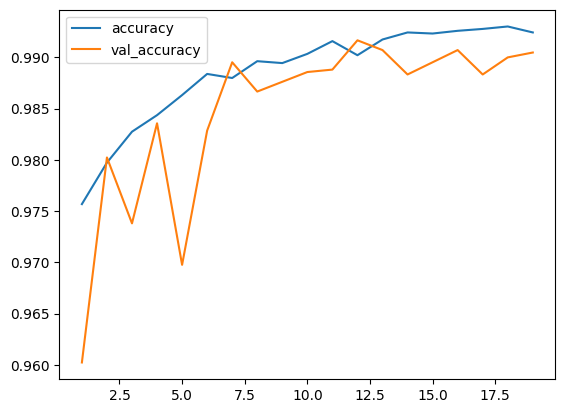

In [14]:
df_history = pd.DataFrame(history.history)
print(f"Best validation loss: {df_history['val_loss'].min()}")
print(f"Best validation accuracy: {df_history['val_accuracy'].max()}")
df_history.loc[1:, ['loss', 'val_loss']].plot()
df_history.loc[1:, ['accuracy', 'val_accuracy']].plot();

Here are some logs of model iterations:
    layers.Conv2D(filters=32, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=64, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(),

    layers.Conv2D(filters=128, kernel_size=3, activation="relu", padding="same"),
    layers.BatchNormalization(),

    layers.GlobalAveragePooling2D(),

    layers.Flatten(),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(10, activation="softmax")
    Best validation loss: 0.042459383606910706
    Best validation accuracy: 0.9902380704879761
---
    Same model as above with image augmentation
    Best validation loss: 0.02707359939813614
    Best validation accuracy: 0.9923809766769409
    